# Multi Layer Perceptron Finetuning Practice with MNIST Data

#### Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cpu  Device: cpu


In [2]:
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


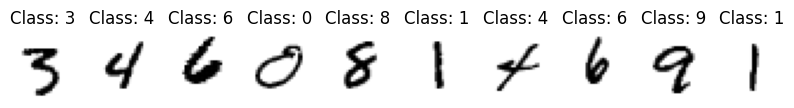

In [5]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

#### Modeling

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5 # dropout 적용 
        self.batch_norm1 = nn.BatchNorm1d(512) # Batch Normalization 적용
        self.batch_norm2 = nn.BatchNorm1d(256) # Batch Normalization 적용

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob) 
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        
        return x

In [7]:
import torch.nn.init as init # 초기화 관련 모듈인 init import
def weight_init(m):
    if isinstance(m, nn.Linear): # MLP 모델 중 nn.Linear에 해당하는 파라미터에 대해 초기화 수행
        init.kaiming_uniform_(m.weight.data) # He initialization (init.kaiming_uniform_ 이 He initialization 의미)

model = Net().to(DEVICE)
model.apply(weight_init) # Net()의 instance인 model에 He initialization 적용
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # Adam optimizer 사용, Learning rate=0.01 적용
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


#### Train & Test

In [8]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.244096
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.490059
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.180158
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.463719
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.093817
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.070205
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.204234
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.152568
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.235419
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.132276

[EPOCH: 1], 	Test Loss: 0.0037, 	Test Accuracy: 96.41 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.073126
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.259856
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.348404
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.607546
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.134995
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.646237
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.404534
T